#### load and train the model along with visualization

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot
import rasterio
import optuna
from torch.utils.data import Dataset, DataLoader
import pickle

# Step 1: Set seed for reproducibility
# Ensures consistent random splits and model initialization
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Step 2: Define save directory and paths
# Specifies where to save the model and hyperparameters
SAVE_DIR = r'C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning'
MODEL_PATH = os.path.join(SAVE_DIR, 'best_cnn_model.pth')
PARAMS_PATH = os.path.join(SAVE_DIR, 'best_params.pkl')
os.makedirs(SAVE_DIR, exist_ok=True)  # Create directory if it doesn't exist

# Step 3: Load and preprocess 30m raster images
# Loads raster files (LST and vegetation indices) and handles NoData values
folder_path = r'C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\30m'
specific_images = ['LST30m.tif', 'NDVI30m.tif', 'IPVI30m.tif', 'MSAVI30m.tif', 'SAVI30m.tif', 'DVI30m.tif']
images_30m = [os.path.join(folder_path, f) for f in specific_images]
arrays_30m = []

for image in images_30m:
    src = rasterio.open(image)
    array = src.read(1)
    array[array == -3.4028230607370965e+38] = np.nan  # Replace NoData with NaN
    arrays_30m.append(array)
    src.close()

# Step 4: Create patches for CNN
# Extracts 5x5 patches from vegetation indices, with LST as the target (center pixel)
def create_patches(arrays, patch_size=5):
    height, width = arrays[0].shape
    patches = []
    targets = []
    coords = []

    for y in range(0, height - patch_size + 1):
        for x in range(0, width - patch_size + 1):
            patch = np.stack([arr[y:y+patch_size, x:x+patch_size] for arr in arrays[1:]], axis=-1)  # Exclude LST
            target = arrays[0][y + patch_size//2, x + patch_size//2]  # Center pixel of LST
            if not np.any(np.isnan(patch)) and not np.isnan(target):
                patches.append(patch)
                targets.append(target)
                coords.append((y + patch_size//2, x + patch_size//2))

    return np.array(patches), np.array(targets), np.array(coords)

patch_size = 5
patches, targets, coords = create_patches(arrays_30m, patch_size)

# Step 5: Split data into train, validation, and test sets
# Splits patches and targets into 70% train, 10% validation, 20% test
X_temp, X_test, y_temp, y_test, coords_temp, coords_test = train_test_split(
    patches, targets, coords, test_size=0.2, random_state=SEED
)
X_train, X_val, y_train, y_val, coords_train, coords_val = train_test_split(
    X_temp, y_temp, coords_temp, test_size=0.125, random_state=SEED
)

# Step 6: Define custom Dataset for CNN
# Converts patches and targets to PyTorch tensors in the correct format
class RasterDataset(Dataset):
    def __init__(self, patches, targets):
        self.patches = torch.tensor(patches, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], self.targets[idx]

# Step 7: Create DataLoaders
# Prepares data for batch processing during training
train_dataset = RasterDataset(X_train, y_train)
val_dataset = RasterDataset(X_val, y_val)
test_dataset = RasterDataset(X_test, y_test)

# Step 8: Define CNN Model
# Defines the CNN architecture with convolutional and fully connected layers
class CNNModel(nn.Module):
    def __init__(self, num_filters, kernel_size, fc_size, dropout_rate):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=num_filters, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters * 2),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dropout_rate)
        )
        conv_output_size = (patch_size // 2) * (patch_size // 2) * (num_filters * 2)
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, fc_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_size, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Step 9: Training function with early stopping
# Trains the model, saves the best model based on validation loss
def train(model, train_loader, val_loader, optimizer, epochs, patience, device, weight_decay):
    model.train()
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"Saved best model to: {MODEL_PATH}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, best_val_loss



#### Hyperparameter tuning with optuna and save best model with best hyperparameters 

[I 2025-04-23 00:23:37,158] A new study created in memory with name: no-name-fc2dcf5d-5290-4788-a6d1-a9ae62066733


Epoch 1, Train Loss: 24.2759, Val Loss: 2.2619
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:23:45,527] Trial 0 finished with value: 2.2618994969947663 and parameters: {'num_filters': 31, 'kernel_size': 5, 'fc_size': 113, 'learning_rate': 0.007664117894874024, 'batch_size': 128, 'dropout_rate': 0.4821047630366532, 'weight_decay': 0.00011170557994603973}. Best is trial 0 with value: 2.2618994969947663.


Epoch 2, Train Loss: 18.3487, Val Loss: 4.0081
Early stopping triggered
Epoch 1, Train Loss: 26.2939, Val Loss: 1.8541
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 6.5038, Val Loss: 1.7546
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 6.3232, Val Loss: 1.6584
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 4, Train Loss: 6.0846, Val Loss: 1.6183
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:24:22,762] Trial 1 finished with value: 1.6182662454652197 and parameters: {'num_filters': 24, 'kernel_size': 3, 'fc_size': 123, 'learning_rate': 0.00011943721070968595, 'batch_size': 32, 'dropout_rate': 0.1941768279170033, 'weight_decay': 7.136769964390958e-05}. Best is trial 1 with value: 1.6182662454652197.


Epoch 5, Train Loss: 5.9695, Val Loss: 1.9053
Early stopping triggered
Epoch 1, Train Loss: 12.6509, Val Loss: 2.0935
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 8.5933, Val Loss: 1.9625
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:25:05,910] Trial 2 finished with value: 1.962472626946323 and parameters: {'num_filters': 28, 'kernel_size': 3, 'fc_size': 86, 'learning_rate': 0.0003762941217222758, 'batch_size': 16, 'dropout_rate': 0.26020894985128384, 'weight_decay': 0.000898192818544346}. Best is trial 1 with value: 1.6182662454652197.


Epoch 3, Train Loss: 8.1564, Val Loss: 2.0436
Early stopping triggered
Epoch 1, Train Loss: 15.1948, Val Loss: 2.6385
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 11.8415, Val Loss: 2.1896
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:25:19,222] Trial 3 finished with value: 2.189646864759511 and parameters: {'num_filters': 28, 'kernel_size': 3, 'fc_size': 116, 'learning_rate': 0.0037383542297766766, 'batch_size': 64, 'dropout_rate': 0.3501484773099529, 'weight_decay': 0.0002729198944369435}. Best is trial 1 with value: 1.6182662454652197.


Epoch 3, Train Loss: 10.3910, Val Loss: 8.5579
Early stopping triggered
Epoch 1, Train Loss: 53.1168, Val Loss: 3.4321
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:25:26,351] Trial 4 finished with value: 3.4320627708061067 and parameters: {'num_filters': 29, 'kernel_size': 5, 'fc_size': 36, 'learning_rate': 0.0028423102484105914, 'batch_size': 128, 'dropout_rate': 0.4149201580043673, 'weight_decay': 0.007887258568154264}. Best is trial 1 with value: 1.6182662454652197.


Epoch 2, Train Loss: 40.6530, Val Loss: 5.1934
Early stopping triggered
Epoch 1, Train Loss: 13.3113, Val Loss: 3.8304
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 9.1569, Val Loss: 2.2767
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:25:42,695] Trial 5 finished with value: 2.276705946408066 and parameters: {'num_filters': 52, 'kernel_size': 5, 'fc_size': 118, 'learning_rate': 0.007979738997358638, 'batch_size': 128, 'dropout_rate': 0.28800843042695945, 'weight_decay': 1.4862003552277737e-06}. Best is trial 1 with value: 1.6182662454652197.


Epoch 3, Train Loss: 8.6291, Val Loss: 2.4874
Early stopping triggered
Epoch 1, Train Loss: 7.7780, Val Loss: 2.2676
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 5.6393, Val Loss: 1.9492
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 4.4243, Val Loss: 1.6899
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:26:54,177] Trial 6 finished with value: 1.6899325901041513 and parameters: {'num_filters': 39, 'kernel_size': 5, 'fc_size': 125, 'learning_rate': 0.0036456614501709406, 'batch_size': 16, 'dropout_rate': 0.19021232436889746, 'weight_decay': 4.0064942823579255e-06}. Best is trial 1 with value: 1.6182662454652197.


Epoch 4, Train Loss: 3.5157, Val Loss: 1.6959
Early stopping triggered
Epoch 1, Train Loss: 10.0769, Val Loss: 2.7374
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 7.3645, Val Loss: 2.4395
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 5.8746, Val Loss: 2.2609
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 4, Train Loss: 4.5068, Val Loss: 1.8380
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:28:12,635] Trial 7 finished with value: 1.837993178838565 and parameters: {'num_filters': 62, 'kernel_size': 3, 'fc_size': 79, 'learning_rate': 0.006657919066106891, 'batch_size': 32, 'dropout_rate': 0.17407055846881703, 'weight_decay': 0.0014306647119808277}. Best is trial 1 with value: 1.6182662454652197.


Epoch 5, Train Loss: 3.6166, Val Loss: 2.6503
Early stopping triggered
Epoch 1, Train Loss: 5.2199, Val Loss: 1.7694
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:28:23,197] Trial 8 finished with value: 1.7694231738597888 and parameters: {'num_filters': 37, 'kernel_size': 3, 'fc_size': 90, 'learning_rate': 0.002830460915925578, 'batch_size': 64, 'dropout_rate': 0.011479889670322319, 'weight_decay': 0.0003724771219199019}. Best is trial 1 with value: 1.6182662454652197.


Epoch 2, Train Loss: 2.2678, Val Loss: 3.6537
Early stopping triggered
Epoch 1, Train Loss: 17.4114, Val Loss: 2.3012
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:28:32,100] Trial 9 finished with value: 2.301246244331886 and parameters: {'num_filters': 31, 'kernel_size': 3, 'fc_size': 63, 'learning_rate': 0.0014122861825636237, 'batch_size': 64, 'dropout_rate': 0.2125122243334106, 'weight_decay': 0.00028394557124735586}. Best is trial 1 with value: 1.6182662454652197.


Epoch 2, Train Loss: 11.1393, Val Loss: 2.6137
Early stopping triggered
Epoch 1, Train Loss: 30.3472, Val Loss: 2.7419
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 3.9866, Val Loss: 2.0773
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:28:54,716] Trial 10 finished with value: 2.077308241379114 and parameters: {'num_filters': 22, 'kernel_size': 3, 'fc_size': 100, 'learning_rate': 0.00010220114205542398, 'batch_size': 32, 'dropout_rate': 0.08462996262232125, 'weight_decay': 1.580049603240507e-05}. Best is trial 1 with value: 1.6182662454652197.


Epoch 3, Train Loss: 3.7323, Val Loss: 2.2970
Early stopping triggered
Epoch 1, Train Loss: 8.6708, Val Loss: 2.8183
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:29:23,962] Trial 11 finished with value: 2.818346948868265 and parameters: {'num_filters': 16, 'kernel_size': 5, 'fc_size': 128, 'learning_rate': 0.0004387364070173693, 'batch_size': 16, 'dropout_rate': 0.12666579964147914, 'weight_decay': 1.3076452307563905e-05}. Best is trial 1 with value: 1.6182662454652197.


Epoch 2, Train Loss: 4.6367, Val Loss: 2.9729
Early stopping triggered
Epoch 1, Train Loss: 11.5928, Val Loss: 2.1485
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 4.4019, Val Loss: 1.9786
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 4.2745, Val Loss: 1.7408
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:30:08,544] Trial 12 finished with value: 1.7408044398566822 and parameters: {'num_filters': 46, 'kernel_size': 5, 'fc_size': 105, 'learning_rate': 0.0001802838033992481, 'batch_size': 32, 'dropout_rate': 0.12444708189472578, 'weight_decay': 1.380474163843165e-06}. Best is trial 1 with value: 1.6182662454652197.


Epoch 4, Train Loss: 4.1877, Val Loss: 1.8447
Early stopping triggered
Epoch 1, Train Loss: 11.1847, Val Loss: 2.1174
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:30:45,751] Trial 13 finished with value: 2.117404870845479 and parameters: {'num_filters': 43, 'kernel_size': 5, 'fc_size': 128, 'learning_rate': 0.0009687414897339148, 'batch_size': 16, 'dropout_rate': 0.31195115094914094, 'weight_decay': 2.0555631850721805e-05}. Best is trial 1 with value: 1.6182662454652197.


Epoch 2, Train Loss: 9.0227, Val Loss: 2.7751
Early stopping triggered
Epoch 1, Train Loss: 10.7901, Val Loss: 3.3517
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 8.4694, Val Loss: 2.0177
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 7.8165, Val Loss: 1.7537
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:31:51,864] Trial 14 finished with value: 1.7537447719550399 and parameters: {'num_filters': 51, 'kernel_size': 3, 'fc_size': 67, 'learning_rate': 0.0008901023340887738, 'batch_size': 16, 'dropout_rate': 0.20193199578047244, 'weight_decay': 4.944560729504749e-06}. Best is trial 1 with value: 1.6182662454652197.


Epoch 4, Train Loss: 7.2406, Val Loss: 1.9258
Early stopping triggered
Epoch 1, Train Loss: 6.9125, Val Loss: 1.6874
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:32:11,379] Trial 15 finished with value: 1.6874392538894842 and parameters: {'num_filters': 37, 'kernel_size': 5, 'fc_size': 101, 'learning_rate': 0.0003767886304482145, 'batch_size': 32, 'dropout_rate': 0.032865214453718705, 'weight_decay': 5.5035533492339644e-05}. Best is trial 1 with value: 1.6182662454652197.


Epoch 2, Train Loss: 2.5984, Val Loss: 1.7618
Early stopping triggered
Epoch 1, Train Loss: 12.0383, Val Loss: 2.3034
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 1.8755, Val Loss: 1.9226
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:32:33,897] Trial 16 finished with value: 1.9225983485763456 and parameters: {'num_filters': 19, 'kernel_size': 5, 'fc_size': 100, 'learning_rate': 0.00026582133855902024, 'batch_size': 32, 'dropout_rate': 0.0026253269419007075, 'weight_decay': 6.192001229419984e-05}. Best is trial 1 with value: 1.6182662454652197.


Epoch 3, Train Loss: 1.7991, Val Loss: 2.7453
Early stopping triggered
Epoch 1, Train Loss: 28.9064, Val Loss: 2.1881
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 3.4428, Val Loss: 1.7661
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 3.2098, Val Loss: 1.7285
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 4, Train Loss: 3.1202, Val Loss: 1.6023
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:33:10,458] Trial 17 finished with value: 1.6022680859506866 and parameters: {'num_filters': 23, 'kernel_size': 3, 'fc_size': 108, 'learning_rate': 0.00010045427861671674, 'batch_size': 32, 'dropout_rate': 0.06451833331755649, 'weight_decay': 4.6142287478171035e-05}. Best is trial 17 with value: 1.6022680859506866.


Epoch 5, Train Loss: 3.1042, Val Loss: 1.9131
Early stopping triggered
Epoch 1, Train Loss: 57.9306, Val Loss: 2.5949
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 9.3295, Val Loss: 1.8947
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:33:32,259] Trial 18 finished with value: 1.894719359462644 and parameters: {'num_filters': 23, 'kernel_size': 3, 'fc_size': 36, 'learning_rate': 0.00010165536309045209, 'batch_size': 32, 'dropout_rate': 0.0946571194175114, 'weight_decay': 3.4240037960699414e-05}. Best is trial 17 with value: 1.6022680859506866.


Epoch 3, Train Loss: 9.1061, Val Loss: 1.9583
Early stopping triggered
Epoch 1, Train Loss: 17.9221, Val Loss: 1.9274
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:33:46,959] Trial 19 finished with value: 1.9274468321859102 and parameters: {'num_filters': 24, 'kernel_size': 3, 'fc_size': 111, 'learning_rate': 0.00019510780664676056, 'batch_size': 32, 'dropout_rate': 0.05549812927569314, 'weight_decay': 6.370771879180155e-06}. Best is trial 17 with value: 1.6022680859506866.


Epoch 2, Train Loss: 3.1339, Val Loss: 1.9729
Early stopping triggered
Epoch 1, Train Loss: 33.3990, Val Loss: 1.9380
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:34:01,124] Trial 20 finished with value: 1.9380229531982798 and parameters: {'num_filters': 19, 'kernel_size': 3, 'fc_size': 70, 'learning_rate': 0.0001599655630081603, 'batch_size': 32, 'dropout_rate': 0.14394927586461015, 'weight_decay': 0.00011690959770627196}. Best is trial 17 with value: 1.6022680859506866.


Epoch 2, Train Loss: 7.6665, Val Loss: 1.9535
Early stopping triggered
Epoch 1, Train Loss: 8.6859, Val Loss: 1.8298
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 3.0345, Val Loss: 1.5480
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:34:25,139] Trial 21 finished with value: 1.5480284595195157 and parameters: {'num_filters': 35, 'kernel_size': 3, 'fc_size': 94, 'learning_rate': 0.0005221605517379774, 'batch_size': 32, 'dropout_rate': 0.051309836353325505, 'weight_decay': 4.9229829506947376e-05}. Best is trial 21 with value: 1.5480284595195157.


Epoch 3, Train Loss: 2.9001, Val Loss: 1.6603
Early stopping triggered
Epoch 1, Train Loss: 7.3861, Val Loss: 1.9680
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 3.4526, Val Loss: 1.8044
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 3.3588, Val Loss: 1.5718
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:34:56,941] Trial 22 finished with value: 1.5718484398759442 and parameters: {'num_filters': 35, 'kernel_size': 3, 'fc_size': 90, 'learning_rate': 0.0006321114671746366, 'batch_size': 32, 'dropout_rate': 0.06726653363032357, 'weight_decay': 0.00012133869514252275}. Best is trial 21 with value: 1.5480284595195157.


Epoch 4, Train Loss: 3.2273, Val Loss: 1.6685
Early stopping triggered
Epoch 1, Train Loss: 7.2369, Val Loss: 2.2777
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:35:13,321] Trial 23 finished with value: 2.277728834564303 and parameters: {'num_filters': 35, 'kernel_size': 3, 'fc_size': 90, 'learning_rate': 0.0006142406598726453, 'batch_size': 32, 'dropout_rate': 0.05616466088941314, 'weight_decay': 0.00016174370309772956}. Best is trial 21 with value: 1.5480284595195157.


Epoch 2, Train Loss: 3.1180, Val Loss: 2.9760
Early stopping triggered
Epoch 1, Train Loss: 5.4733, Val Loss: 1.9766
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 3.3278, Val Loss: 1.6661
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 3.1770, Val Loss: 1.6450
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 4, Train Loss: 3.0338, Val Loss: 1.5195
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:36:05,394] Trial 24 finished with value: 1.5194607368957849 and parameters: {'num_filters': 43, 'kernel_size': 3, 'fc_size': 81, 'learning_rate': 0.0014779971196139468, 'batch_size': 32, 'dropout_rate': 0.053658220299143244, 'weight_decay': 0.000741368760636933}. Best is trial 24 with value: 1.5194607368957849.


Epoch 5, Train Loss: 2.9527, Val Loss: 1.7221
Early stopping triggered
Epoch 1, Train Loss: 8.2506, Val Loss: 2.0859
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:36:23,749] Trial 25 finished with value: 2.085917379532331 and parameters: {'num_filters': 45, 'kernel_size': 3, 'fc_size': 54, 'learning_rate': 0.0018169078713306413, 'batch_size': 32, 'dropout_rate': 0.1037586724833051, 'weight_decay': 0.0013245140106069564}. Best is trial 24 with value: 1.5194607368957849.


Epoch 2, Train Loss: 6.1155, Val Loss: 2.3343
Early stopping triggered
Epoch 1, Train Loss: 10.4306, Val Loss: 3.5417
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 7.6424, Val Loss: 1.8540
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 7.1412, Val Loss: 1.7174
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:37:11,388] Trial 26 finished with value: 1.7174029921307976 and parameters: {'num_filters': 49, 'kernel_size': 3, 'fc_size': 76, 'learning_rate': 0.0013784580644955208, 'batch_size': 32, 'dropout_rate': 0.1537530315790567, 'weight_decay': 0.003971326326665683}. Best is trial 24 with value: 1.5194607368957849.


Epoch 4, Train Loss: 6.5656, Val Loss: 2.7107
Early stopping triggered
Epoch 1, Train Loss: 6.0534, Val Loss: 3.2746
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:37:31,964] Trial 27 finished with value: 3.2745945818630267 and parameters: {'num_filters': 56, 'kernel_size': 3, 'fc_size': 88, 'learning_rate': 0.0006422796575742555, 'batch_size': 32, 'dropout_rate': 0.03805968276822887, 'weight_decay': 0.0006391930447254489}. Best is trial 24 with value: 1.5194607368957849.


Epoch 2, Train Loss: 2.7302, Val Loss: 3.9090
Early stopping triggered
Epoch 1, Train Loss: 23.8495, Val Loss: 2.0283
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 5.5979, Val Loss: 1.6279
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:37:43,214] Trial 28 finished with value: 1.6278984114235522 and parameters: {'num_filters': 42, 'kernel_size': 3, 'fc_size': 56, 'learning_rate': 0.0005812224644464616, 'batch_size': 128, 'dropout_rate': 0.08779826944401356, 'weight_decay': 0.002168290355071756}. Best is trial 24 with value: 1.5194607368957849.


Epoch 3, Train Loss: 5.4073, Val Loss: 1.8239
Early stopping triggered
Epoch 1, Train Loss: 5.7682, Val Loss: 5.6763
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 2.0927, Val Loss: 1.9572
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 1.9618, Val Loss: 1.6102
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 4, Train Loss: 1.8787, Val Loss: 1.5358
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


[I 2025-04-23 00:38:07,891] Trial 29 finished with value: 1.5358303603280354 and parameters: {'num_filters': 33, 'kernel_size': 3, 'fc_size': 95, 'learning_rate': 0.0015746500983313332, 'batch_size': 64, 'dropout_rate': 0.007362155850435412, 'weight_decay': 0.00014836291438427197}. Best is trial 24 with value: 1.5194607368957849.


Epoch 5, Train Loss: 1.7728, Val Loss: 2.4272
Early stopping triggered
Best hyperparameters: {'num_filters': 43, 'kernel_size': 3, 'fc_size': 81, 'learning_rate': 0.0014779971196139468, 'batch_size': 32, 'dropout_rate': 0.053658220299143244, 'weight_decay': 0.000741368760636933}
Saved best hyperparameters to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_params.pkl
Epoch 1, Train Loss: 5.5394, Val Loss: 2.3602
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 2, Train Loss: 3.3327, Val Loss: 1.8271
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 3, Train Loss: 3.2279, Val Loss: 1.9178
Epoch 4, Train Loss: 3.1081, Val Loss: 1.6906
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
Epoch 5, Train Loss: 3.0290, Val Loss: 1.6216
Saved best model to: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\Augus

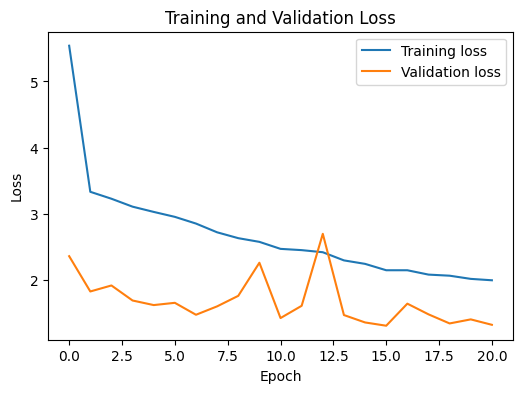

In [2]:
# Step 10: Optuna objective function
# Defines hyperparameter search space and trains model for each trial
def objective(trial):
    num_filters = trial.suggest_int('num_filters', 16, 64)
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    fc_size = trial.suggest_int('fc_size', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0,
                                       0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(
        num_filters=num_filters,
        kernel_size=kernel_size,
        fc_size=fc_size,
        dropout_rate=dropout_rate
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    _, _, val_loss = train(
        model,
        train_loader,
        val_loader,
        optimizer,
        epochs=30,
        patience=0,
        device=device,
        weight_decay=weight_decay
    )

    return val_loss

# Step 11: Run Optuna optimization
# Finds the best hyperparameters over 30 trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Step 12: Save best hyperparameters
# Saves the best hyperparameters to a pickle file
best_params = study.best_params
with open(PARAMS_PATH, 'wb') as f:
    pickle.dump(best_params, f)
print(f"Best hyperparameters: {best_params}")
print(f"Saved best hyperparameters to: {PARAMS_PATH}")

# Step 13: Train final model with best hyperparameters
# Trains the model with the best hyperparameters for final evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

model = CNNModel(
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    fc_size=best_params['fc_size'],
    dropout_rate=best_params['dropout_rate']
).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

train_losses, val_losses, _ = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    epochs=50,
    patience=5,
    device=device,
    weight_decay=best_params['weight_decay']
)


# Step 18: Plot training and validation losses
# Visualizes training progress to assess convergence
pyplot.figure(figsize=(6, 4))
pyplot.plot(train_losses, label="Training loss")
pyplot.plot(val_losses, label="Validation loss")
pyplot.legend(loc="upper right")
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.title("Training and Validation Loss")
pyplot.show()

In [ ]:
#### data visualization and model evaluation on 30m image

C:\Users\KIRAM\AppData\Local\Temp\ipykernel_27384\1148209209.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Loaded best model from: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth
R²: 0.8790, RMSE: 1.1358


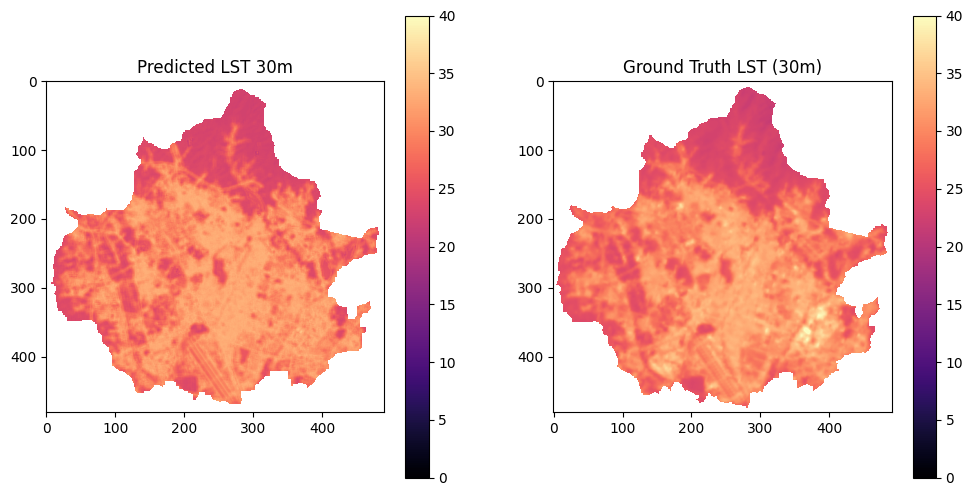

In [3]:
# Step 14: Load best model for evaluation
# Loads the saved model for final predictions
model.load_state_dict(torch.load(MODEL_PATH))
print(f"Loaded best model from: {MODEL_PATH}")
model.eval()

# Step 15: Predict on entire 30m dataset
# Generates predictions for all valid patches
dataset = RasterDataset(patches, targets)
loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=False)
y_pred = []
with torch.no_grad():
    for inputs, _ in loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy().flatten())

# Step 16: Evaluate predictions
# Computes R² and RMSE for the 30m predictions
r2 = r2_score(targets, y_pred)
rmse = np.sqrt(mean_squared_error(targets, y_pred))
print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}")

# Step 17: Visualize 30m predictions
# Plots predicted vs. ground truth LST, matching previous visualization
nodata_value = -3.4028230607370965e+38
with rasterio.open(r"C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\30m\LST30m.tif") as src:
    lst_array = src.read(1)
    lst_array[lst_array == nodata_value] = np.nan

    mat = np.full(lst_array.shape, np.nan)
    for i, (y, x) in enumerate(coords):
        mat[int(y), int(x)] = y_pred[i]

    pyplot.figure(figsize=(12, 6))
    pyplot.subplot(1, 2, 1)
    pyplot.title("Predicted LST 30m")
    pyplot.imshow(mat, cmap='magma', vmin=0, vmax=40)
    pyplot.colorbar()

    pyplot.subplot(1, 2, 2)
    pyplot.title("Ground Truth LST (30m)")
    pyplot.imshow(lst_array, cmap='magma', vmin=0, vmax=40)
    pyplot.colorbar()

    pyplot.show()


#### load the model and predict the script for 3 m data

In [6]:
#import the libraries such as pickle for the saved trained model
import os
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot
import rasterio
from torch.utils.data import Dataset, DataLoader
import pickle


In [7]:

# Step 1: Define paths
# Specifies the location of the saved model and hyperparameters which we have already trained in above steps
SAVE_DIR = r'C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning'
MODEL_PATH = os.path.join(SAVE_DIR, 'best_cnn_model.pth')
PARAMS_PATH = os.path.join(SAVE_DIR, 'best_params.pkl')

# Step 2: Load best hyperparameters
# Loads the hyperparameters needed to initialize the model
if not os.path.exists(PARAMS_PATH):
    raise FileNotFoundError(f"Hyperparameters file not found at: {PARAMS_PATH}")
with open(PARAMS_PATH, 'rb') as f:
    best_params = pickle.load(f)
print(f"Loaded best hyperparameters from: {PARAMS_PATH}")
print(f"Best hyperparameters: {best_params}")


Loaded best hyperparameters from: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_params.pkl
Best hyperparameters: {'num_filters': 43, 'kernel_size': 3, 'fc_size': 81, 'learning_rate': 0.0014779971196139468, 'batch_size': 32, 'dropout_rate': 0.053658220299143244, 'weight_decay': 0.000741368760636933}


In [8]:
### redefining the architecture which must match the artitecthure while training
# Step 3: Define CNNModel
# Must match the architecture used during training
class CNNModel(nn.Module):
    def __init__(self, num_filters, kernel_size, fc_size, dropout_rate):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=num_filters, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters * 2),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dropout_rate)
        )
        conv_output_size = (5 // 2) * (5 // 2) * (num_filters * 2)  # Assuming patch_size=5
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, fc_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_size, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [9]:
# Step 4: Custom Dataset for prediction
# Prepares 3m patches for prediction (no targets needed)
class RasterDataset(Dataset):
    def __init__(self, patches):
        self.patches = torch.tensor(patches, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]

In [10]:
# Step 5: Load and preprocess 3m raster images
# Loads 3m vegetation index rasters and handles NoData values
folder_path = r'C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\3m'
specific_images = ['NDVI3m.tif', 'IPVI3m.tif', 'MSAVI3m.tif', 'SAVI3m.tif', 'DVI3m.tif']
images_3m = [os.path.join(folder_path, f) for f in specific_images]
arrays_3m = []

for image in images_3m:
    src = rasterio.open(image)
    array = src.read(1)
    array[array == -3.4028230607370965e+38] = np.nan
    arrays_3m.append(array)
    src.close()

# Step 6: Create patches for 3m data
# Extracts 5x5 patches from 3m rasters for prediction
def create_patches_for_prediction(arrays, patch_size=5):
    height, width = arrays[0].shape
    patches = []
    coords = []

    for y in range(0, height - patch_size + 1):
        for x in range(0, width - patch_size + 1):
            patch = np.stack([arr[y:y+patch_size, x:x+patch_size] for arr in arrays], axis=-1)
            if not np.any(np.isnan(patch)):
                patches.append(patch)
                coords.append((y + patch_size//2, x + patch_size//2))

    return np.array(patches), np.array(coords)

patch_size = 5
patches_3m, coords_3m = create_patches_for_prediction(arrays_3m, patch_size)

In [11]:
# Step 7: Create dataset and loader for 3m data
# Prepares 3m patches for batch processing
dataset_3m = RasterDataset(patches_3m)
loader_3m = DataLoader(dataset_3m, batch_size=best_params['batch_size'], shuffle=False)

# Step 8: Load the best model
# Loads the trained model for prediction
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at: {MODEL_PATH}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    fc_size=best_params['fc_size'],
    dropout_rate=best_params['dropout_rate']
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
print(f"Loaded model from: {MODEL_PATH}")
model.eval()


Loaded model from: C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\best_cnn_model.pth


C:\Users\KIRAM\AppData\Local\Temp\ipykernel_27384\2185069790.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=d

CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(5, 43, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(43, 86, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.053658220299143244, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=344, out_features=81, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.053658220299143244, inplace=False)
    (3): Linear(in_features=81, out_features=1, bias=True)
  )
)

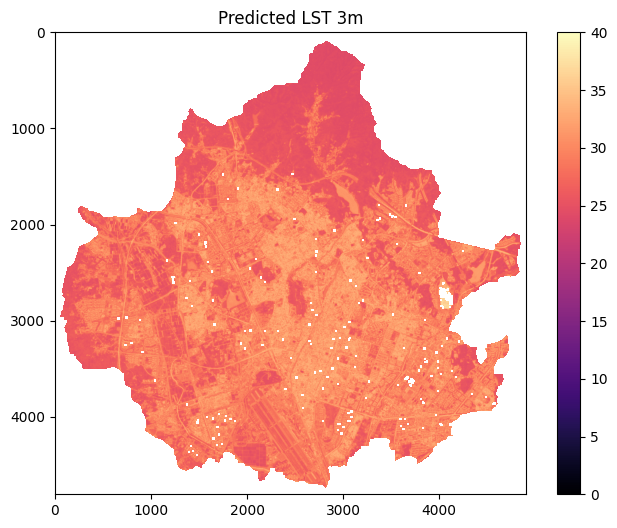

In [12]:
#Final step - Step 9: Make predictions on 3m data
# Generates LST predictions for 3m patches
y_pred_3m = []
with torch.no_grad():
    for inputs in loader_3m:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred_3m.extend(outputs.cpu().numpy().flatten())

# Step 10: Visualize 3m predictions
# Plots the predicted LST for 3m data
height, width = arrays_3m[0].shape
mat_3m = np.full((height, width), np.nan)
for i, (y, x) in enumerate(coords_3m):
    mat_3m[int(y), int(x)] = y_pred_3m[i]

pyplot.figure(figsize=(8, 6))
pyplot.title("Predicted LST 3m")
pyplot.imshow(mat_3m, cmap='magma', vmin=0, vmax=40)
pyplot.colorbar()
pyplot.show()

In [14]:
import rasterio
import os
import numpy as np

# Define output path
output_path = os.path.join(folder_path, 'predicted_LST_3mCNN.tif')

# Use profile from one of the 3m rasters (e.g., NDVI)
with rasterio.open(images_3m[0]) as src:
    profile = src.profile

# Update the profile for single-band float32 data
profile.update(
    dtype=rasterio.float32,
    count=1,
    nodata=-3.4028230607370965e+38
)

# Save the predicted LST
with rasterio.open(output_path, 'w', **profile) as dst:
    mat_3m_filled = mat_3m.copy()
    mat_3m_filled[np.isnan(mat_3m_filled)] = -3.4028230607370965e+38  # Fill NaNs
    dst.write(mat_3m_filled.astype(np.float32), 1)

print(f"Saved predicted LST at 3m to:\n{output_path}")


Saved predicted LST at 3m to:
C:\Users\KIRAM\Desktop\Project_UHI\Suwon\August\MachineLearning\3m\predicted_LST_3mCNN.tif
